# 1. Подготовка данных

In [1]:
# импортируем библиотеки:
import warnings
warnings.filterwarnings('ignore')

import optuna
import mlflow
import joblib
import seaborn as sns
import pandas as pd
import xgboost as xgb
import numpy as np
import requests
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, balanced_accuracy_score

mlflow.set_tracking_uri("http://127.0.0.1:9000")
client=mlflow.MlflowClient(tracking_uri='http://127.0.0.1:9000')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# загрузим файл:
df = pd.read_csv('Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
# проверим наличие явных дубликатов:
df.duplicated().sum()

0

In [6]:
# посмотрим уникальные значения в категориальных признаках:
cat_columns = ['Geography', 'Tenure', 'NumOfProducts', 'Gender', 'HasCrCard', 'IsActiveMember']
for col in cat_columns:
    display(df[col].value_counts())

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Tenure
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: count, dtype: int64

NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

Gender
Male      5457
Female    4543
Name: count, dtype: int64

HasCrCard
1    7055
0    2945
Name: count, dtype: int64

IsActiveMember
1    5151
0    4849
Name: count, dtype: int64

In [7]:
# посчитаем классы в целевом признаке:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

Можно отметить, что дубликаты в датасете отсутствуют, в столбце Tenure есть около тысячи пропусков, а также несколько столбцов лучше вообще удалить, из них:

- RowNumber - это индекс строки в данных, важной информации не содержит;
- CustomerId - уникальный идентификатор клиента, по нему мы проверили дубликаты и теперь его можно удалить;
- Surname - фамилия, которая тоже не имеет связи с оттоком клиентов.

После проверки датасета на сбалансированность классов в таргете мы видим, что объектов отрицательного класса намного больше (почти в четыре раза), но все равно уходит примерно 20% клиентов. В столбце Geography находятся всего 3 уникальных значения: France, Germany и Spain. В столбце Tenure (сколько лет человек является клиентом банка) есть 909 пропусков. Заполним их значением -1, добавив логический параметр add_indicator=True. Есть несколько бинарных признаков (HasCrCard, IsActiveMember), которые выделим в отдельную категорию признаков.

In [8]:
# удалим ненужные столбцы:
df.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

In [9]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [11]:
# сохраним признаки и целевой признак в отдельных переменных:
y = df['Exited']
X = df.drop('Exited', axis=1)

In [12]:
# разобьем исходные данные на обучающую и тестовую выборки в соотношении 4:1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)

In [13]:
# посмотрим на размеры выборок:
print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (8000, 10)
Размер тестовой выборки: (2000, 10)


In [14]:
# внесем в переменные списки все численные и категориальные признаки:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
binary_features = ['HasCrCard', 'IsActiveMember']
numeric_features = list(set(numeric_features) - set(binary_features))

# 2. Обучение модели без учёта дисбаланса классов (XGBoost)

Для автоматизации процесса подготовим численный и категориальный пайплайны.
- Для категориальных признаков (Geography, Gender) используем One Hot Encoding.
- Для заполнения пропусков используем SimpleImputer.
- Выполним трансформацию Йео-Джонсона.
- Для моделей логистической регрессии и SVM выполним масштабирование данных; для моделей, основанных на деревьях (XGBoost и Random Forest), выполнять его не будем.
- Объединим пайплайны классом ColumnTransformer.
- Используем optuna для автоматизированного поиска оптимальных гиперпараметров для моделей.
- Используем mlflow для того, чтобы легко выбрать лучшие модели среди всех экспериментов и при этом легко сравнивать метрики качества (будем сравнивать f1 на кроссвалидации, на тестовом наборе сравним f1, ROC-AUC и balanced accuracy).

In [15]:
cat_pipeline = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='error', drop='first'))
])

num_pipeline = Pipeline([
    ('imp', SimpleImputer(fill_value=-1, add_indicator=True)),
    ('pt', PowerTransformer()) 
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)

], remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier())
])

In [16]:
def optuna_optimize(trial):
    param_grid = {
        'model__n_estimators': trial.suggest_int('model__n_estimators', 50, 500),
        'model__max_depth': trial.suggest_int('model__max_depth', 2, 16),
        'model__learning_rate': trial.suggest_float('model__learning_rate', 0.01, 1.0),
        'model__gamma': trial.suggest_float('model__gamma', 0.0, 20.0),
        'model__reg_alpha': trial.suggest_float('model__reg_alpha', 0.0, 1.0),
        'model__reg_lambda': trial.suggest_float('model__reg_lambda', 0.0, 1.0),
        'model__min_child_weight': trial.suggest_float('model__min_child_weight', 0.0, 5.0),
        'model__subsample': trial.suggest_float('model__subsample', 0.5, 1.0),
        'model__colsample_bytree': trial.suggest_float('model__colsample_bytree', 0.5, 1.0),
        'model__colsample_bylevel': trial.suggest_float('model__colsample_bylevel', 0.5, 1.0),
        'model__colsample_bynode': trial.suggest_float('model__colsample_bynode', 0.5, 1.0),
        'model__random_state': 12345
    }

    pipe.set_params(**param_grid)
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [17]:
study_xgb = optuna.create_study(study_name="XGBoost Optuna Optimization Imbalanced",
                                direction='maximize')

In [18]:
study_xgb.optimize(optuna_optimize, n_trials=1000)

In [19]:
print("Наилучшие значения гиперпараметров XGBoost: {}".format(study_xgb.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_xgb.best_value))

Наилучшие значения гиперпараметров XGBoost: {'model__n_estimators': 296, 'model__max_depth': 4, 'model__learning_rate': 0.24455219155198604, 'model__gamma': 2.279536035885957, 'model__reg_alpha': 0.9126935818965531, 'model__reg_lambda': 0.9688200693813175, 'model__min_child_weight': 2.786519071319251, 'model__subsample': 0.695765566288553, 'model__colsample_bytree': 0.6436589973573024, 'model__colsample_bylevel': 0.6487715603665177, 'model__colsample_bynode': 0.8778456304460163}
f1_score на обучающем наборе: 0.600


In [20]:
with mlflow.start_run(nested=True,
                      run_name='xgb_pipeline_imbalanced'):

    best_params = study_xgb.best_params
    best_score = study_xgb.best_value
    mlflow.log_params(best_params)

    pipe.set_params(**best_params)
    pipe.fit(X_train, y_train)
    pred_proba = pipe.predict_proba(X_test)[:, 1]
    roc_auc_xgb_imb = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_xgb_imb,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba)),
        'f1': f1_score(y_test, np.round(pred_proba))
    })

    mlflow.sklearn.log_model(pipe, 'xgb_pipeline_imbalanced')

# 3. Обучение моделей с учётом дисбаланса классов
## 3.1 Назначение разных весов классам (cost-sensitive learning)
### 3.1.1 Модель XGBoost

In [21]:
cat_pipeline = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='error', drop='first'))
])

num_pipeline = Pipeline([
    ('imp', SimpleImputer(fill_value=-1, add_indicator=True)),
    ('pt', PowerTransformer())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)

], remainder='passthrough')

In [22]:
def optuna_optimize(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 20.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.0, 5.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0)
    }

    estimator = xgb.XGBClassifier(**param, 
                                  scale_pos_weight=3.91,
                                  random_state=12345)
    
    xgb_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])

    score = cross_val_score(xgb_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [23]:
study_xgb_cw = optuna.create_study(study_name="XGBoost Optuna Optimization Class Weight",
                                direction='maximize')

In [24]:
study_xgb_cw.optimize(optuna_optimize, n_trials=1000)

In [25]:
print("Наилучшие значения гиперпараметров XGBoost: {}".format(study_xgb_cw.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_xgb_cw.best_value))

Наилучшие значения гиперпараметров XGBoost: {'n_estimators': 177, 'max_depth': 11, 'learning_rate': 0.010885060551220984, 'gamma': 0.3759707328727563, 'reg_lambda': 0.4481878181883802, 'reg_alpha': 0.46347980468616645, 'min_child_weight': 1.3225044978338598, 'subsample': 0.5407832262689065, 'colsample_bytree': 0.9173484427584284, 'colsample_bylevel': 0.9920977308892406, 'colsample_bynode': 0.8730014884762016}
f1_score на обучающем наборе: 0.627


In [26]:
with mlflow.start_run(nested=True,
                      run_name='xgb_pipeline_class_weight'):

    best_params = study_xgb_cw.best_params
    best_score = study_xgb_cw.best_value
    mlflow.log_params(best_params)

    xgb_pipe_cw = Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb.XGBClassifier(**best_params,
                                    scale_pos_weight=3.91,
                                    random_state=12345))
    ])

    xgb_pipe_cw.fit(X_train, y_train) 

    pred_proba = xgb_pipe_cw.predict_proba(X_test)[:, 1]
    roc_auc_xgb_cw = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_xgb_cw,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })

    mlflow.sklearn.log_model(xgb_pipe_cw, 'xgb_pipeline_class_weight')

### 3.1.2 Случайный лес

In [27]:
def optuna_optimize(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300), 
        'max_depth': trial.suggest_int('max_depth', 2, 10), 
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    if param['bootstrap']:
        param['max_samples'] = trial.suggest_float('max_samples', 0.5, 1.0)

    estimator = RandomForestClassifier(**param, 
                                       class_weight='balanced',
                                       random_state=12345)

    rf_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])

    score = cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [28]:
study_rf = optuna.create_study(study_name="RandomForest Optuna Optimization Class Weight",
                                direction='maximize')

In [29]:
study_rf.optimize(optuna_optimize, n_trials=100)

In [30]:
print("Наилучшие значения гиперпараметров Random Forest: {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_rf.best_value))

Наилучшие значения гиперпараметров Random Forest: {'n_estimators': 129, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 11, 'bootstrap': True, 'max_samples': 0.5889054391127376}
f1_score на обучающем наборе: 0.622


In [31]:
with mlflow.start_run(nested=True,
                      run_name='rf_pipeline_class_weight'):

    best_params = study_rf.best_params
    best_score = study_rf.best_value
    mlflow.log_params(best_params)

    rf_pipe_cw = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(**best_params,
                                         class_weight='balanced',
                                         random_state=12345))
    ])

    rf_pipe_cw.fit(X_train, y_train)

    pred_proba = rf_pipe_cw.predict_proba(X_test)[:, 1]
    roc_auc_rf_cw = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_rf_cw,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })
    
    mlflow.sklearn.log_model(rf_pipe_cw, 'rf_pipeline_class_weight')

### 3.1.3 Логистическая регрессия

In [32]:
cat_pipeline = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='error', drop='first'))
])

num_pipeline = Pipeline([
    ('imp', SimpleImputer(fill_value=-1, add_indicator=True)),
    ('pt', PowerTransformer()),
    ('scal', StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)
], remainder='passthrough')

In [33]:
def optuna_optimize(trial):
    param = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga']),
        'C': trial.suggest_float('C', 0.01, 100),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'tol': trial.suggest_float('tol', 1e-4, 1e-2)
    }

    if param['solver'] == 'lbfgs':
        param['penalty'] = 'l2'
    elif param['solver'] == 'saga':
        param['penalty'] = trial.suggest_categorical('penalty', ['elasticnet', 'l1', 'l2'])
        if param['penalty'] == 'elasticnet':
            param['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)
        
    estimator = LogisticRegression(**param,  
                                   class_weight='balanced',
                                   random_state=12345)

    log_reg_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])
    
    score = cross_val_score(log_reg_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [34]:
study_log_reg = optuna.create_study(study_name="LogisticRegression Optuna Optimization Class Weight",
                                direction='maximize')

In [35]:
study_log_reg.optimize(optuna_optimize, n_trials=100)

In [36]:
print("Наилучшие значения гиперпараметров Logistic Regression: {}".format(study_log_reg.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_log_reg.best_value))

Наилучшие значения гиперпараметров Logistic Regression: {'solver': 'saga', 'C': 0.022392897651073544, 'max_iter': 805, 'tol': 0.009752579277906546, 'penalty': 'elasticnet', 'l1_ratio': 0.007455973771905782}
f1_score на обучающем наборе: 0.495


In [37]:
with mlflow.start_run(nested=True,
                      run_name='log_reg_pipeline_class_weight'):

    best_params = study_log_reg.best_params
    best_score = study_log_reg.best_value
    mlflow.log_params(best_params)

    log_reg_pipe_cw = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(**best_params,
                                     class_weight='balanced',
                                     random_state=12345))
    ])

    log_reg_pipe_cw.fit(X_train, y_train)

    pred_proba = log_reg_pipe_cw.predict_proba(X_test)[:, 1]
    roc_auc_lr_cw = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_lr_cw,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })
    
    mlflow.sklearn.log_model(log_reg_pipe_cw, 'log_reg_pipeline_class_weight')

### 3.1.4 Метод опорных векторов

In [38]:
def optuna_optimize(trial):

    param = {
        'C': trial.suggest_float('C', 0.01, 3),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
    }
 
    estimator = SVC(**param, 
                    class_weight='balanced',
                    random_state=12345,
                    probability=True)
    
    svc_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])
    
    score = cross_val_score(svc_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [39]:
study_svc = optuna.create_study(study_name="SVC Optuna Optimization Class Weight",
                                    direction='maximize')

In [40]:
study_svc.optimize(optuna_optimize, n_trials=10)

In [41]:
print("Наилучшие значения гиперпараметров SVC: {}".format(study_svc.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_svc.best_value))

Наилучшие значения гиперпараметров SVC: {'C': 2.494665176169719, 'gamma': 'auto'}
f1_score на обучающем наборе: 0.580


In [42]:
with mlflow.start_run(nested=True,
                      run_name='svc_pipeline_class_weight'):

    best_params = study_svc.best_params
    best_score = study_svc.best_value
    mlflow.log_params(best_params)

    svc_pipe_cw = Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(**best_params,
                      class_weight='balanced',
                      random_state=12345,
                      probability=True))
    ])

    svc_pipe_cw.fit(X_train, y_train)

    pred_proba = svc_pipe_cw.predict_proba(X_test)[:, 1]
    roc_auc_svc_cw = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_svc_cw,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })
    
    mlflow.sklearn.log_model(svc_pipe_cw, 'svc_pipeline_class_weight')

## 3.2 Генерация синтетических данных (SMOTE)
### 3.2.1 Модель XGBoost

In [71]:
cat_pipeline = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='error', drop='first', sparse_output=False))
])

num_pipeline = Pipeline([
    ('imp', SimpleImputer(fill_value=-1, add_indicator=True)),
    ('pt', PowerTransformer())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)
], remainder='passthrough')

In [72]:
def optuna_optimize(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 20.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.0, 5.0)
    }

    estimator = xgb.XGBClassifier(**param,
                                  random_state=12345)

    xgb_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', estimator)
    ])

    score = cross_val_score(xgb_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [73]:
study_xgb_smote = optuna.create_study(study_name="XGBoost Optuna Optimization SMOTE",
                                direction='maximize')

In [74]:
study_xgb_smote.optimize(optuna_optimize, n_trials=2000)

In [75]:
print("Наилучшие значения гиперпараметров XGBoost: {}".format(study_xgb_smote.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_xgb_smote.best_value))

Наилучшие значения гиперпараметров XGBoost: {'n_estimators': 244, 'max_depth': 11, 'learning_rate': 0.2314719892226636, 'gamma': 11.338936897141163, 'reg_lambda': 0.8890455196207231, 'min_child_weight': 0.5637195252824914}
f1_score на обучающем наборе: 0.631


In [76]:
with mlflow.start_run(nested=True,
                      run_name='xgb_pipeline_smote'):

    best_params = study_xgb_smote.best_params
    best_score = study_xgb_smote.best_value
    mlflow.log_params(best_params)

    xgb_pipe_sm = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', xgb.XGBClassifier(**best_params,
                                    random_state=12345))
    ])

    xgb_pipe_sm.fit(X_train, y_train)

    pred_proba = xgb_pipe_sm.predict_proba(X_test)[:, 1]
    roc_auc_xgb_sm = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_xgb_sm,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })

    mlflow.sklearn.log_model(xgb_pipe_sm, 'xgb_pipeline_smote')

### 3.2.2 Случайный лес

In [49]:
def optuna_optimize(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    if param['bootstrap']:
        param['max_samples'] = trial.suggest_float('max_samples', 0.5, 1.0)

    estimator = RandomForestClassifier(**param,
                                       random_state=12345)

    rf_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', estimator)
    ])

    score = cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [50]:
study_rf_smote = optuna.create_study(study_name="RandomForest Optuna Optimization SMOTE",
                               direction='maximize')

In [51]:
study_rf_smote.optimize(optuna_optimize, n_trials=100)

In [52]:
print("Наилучшие значения гиперпараметров RandomForest: {}".format(study_rf_smote.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_rf_smote.best_value))

Наилучшие значения гиперпараметров RandomForest: {'n_estimators': 188, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 18, 'bootstrap': True, 'max_samples': 0.9678236874658844}
f1_score на обучающем наборе: 0.612


In [53]:
with mlflow.start_run(nested=True,
                      run_name='rf_pipeline_smote'):

    best_params = study_rf_smote.best_params
    best_score = study_rf_smote.best_value
    mlflow.log_params(best_params)

    rf_pipe_sm = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', RandomForestClassifier(**best_params,
                                         random_state=12345))
    ])

    rf_pipe_sm.fit(X_train, y_train)

    pred_proba = rf_pipe_sm.predict_proba(X_test)[:, 1]
    roc_auc_rf_sm = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_rf_sm,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })
    
    mlflow.sklearn.log_model(rf_pipe_sm, 'rf_pipeline_smote')

### 3.2.3 Логистическая регрессия

In [54]:
cat_pipeline = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='error', drop='first'))
])

num_pipeline = Pipeline([
    ('imp', SimpleImputer(fill_value=-1, add_indicator=True)),
    ('pt', PowerTransformer()),
    ('scal', StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)
], remainder='passthrough')

In [55]:
def optuna_optimize(trial):
    param = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga']),
        'C': trial.suggest_float('C', 0.01, 100),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'tol': trial.suggest_float('tol', 1e-4, 1e-2)
    }

    if param['solver'] == 'lbfgs':
        param['penalty'] = 'l2'
    elif param['solver'] == 'saga':
        param['penalty'] = trial.suggest_categorical('penalty', ['elasticnet', 'l1', 'l2'])
        if param['penalty'] == 'elasticnet':
            param['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)

    estimator = LogisticRegression(**param,
                                   random_state=12345)

    log_reg_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', estimator)
    ])

    score = cross_val_score(log_reg_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    return score

In [56]:
study_log_reg_smote = optuna.create_study(study_name="LogisticRegression Optuna Optimization SMOTE",
                                    direction='maximize')

In [57]:
study_log_reg_smote.optimize(optuna_optimize, n_trials=100)

In [58]:
print("Наилучшие значения гиперпараметров Logistic Regression: {}".format(study_log_reg_smote.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_log_reg_smote.best_value))

Наилучшие значения гиперпараметров Logistic Regression: {'solver': 'saga', 'C': 13.03512753774626, 'max_iter': 183, 'tol': 0.0032527138638601904, 'penalty': 'l2'}
f1_score на обучающем наборе: 0.493


In [59]:
with mlflow.start_run(nested=True,
                      run_name='log_reg_pipeline_smote'):

    best_params = study_log_reg_smote.best_params
    best_score = study_log_reg_smote.best_value
    mlflow.log_params(best_params)

    log_reg_pipe_sm = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', LogisticRegression(**best_params,
                                     random_state=12345))
    ])

    log_reg_pipe_sm.fit(X_train, y_train)

    pred_proba = log_reg_pipe_sm.predict_proba(X_test)[:, 1]
    roc_auc_lr_sm = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_lr_sm,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })

    mlflow.sklearn.log_model(log_reg_pipe_sm, 'log_reg_pipeline_smote')

### 3.2.4 Метод опорных векторов

In [60]:
def optuna_optimize(trial):

    param = {
        'C': trial.suggest_float('C', 0.01, 3),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
    }

    estimator = SVC(**param,
                    random_state=12345,
                    probability=True)

    svc_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', estimator)
    ])

    score = cross_val_score(svc_pipe, X_train, y_train, cv=5, scoring='f1').mean()
    
    return score

In [61]:
study_svc_smote = optuna.create_study(study_name="SVC Optuna Optimization SMOTE",
                                direction='maximize')

In [62]:
study_svc_smote.optimize(optuna_optimize, n_trials=10)

In [63]:
print("Наилучшие значения гиперпараметров SVC: {}".format(study_svc_smote.best_params))
print("f1_score на обучающем наборе: {:.3f}". format(study_svc_smote.best_value))

Наилучшие значения гиперпараметров SVC: {'C': 2.9807723829645663, 'gamma': 'auto'}
f1_score на обучающем наборе: 0.578


In [64]:
with mlflow.start_run(nested=True,
                      run_name='svc_pipeline_smote'):

    best_params = study_svc_smote.best_params
    best_score = study_svc_smote.best_value
    mlflow.log_params(best_params)

    svc_pipe_sm = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=12345)),
        ('model', SVC(**best_params,
                      random_state=12345,
                      probability=True))
    ])

    svc_pipe_sm.fit(X_train, y_train)
    pred_proba = svc_pipe_sm.predict_proba(X_test)[:, 1]
    roc_auc_svc_sm = roc_auc_score(y_test, pred_proba)
    
    mlflow.log_metrics({
        'f1_cv': best_score,
        'roc_auc': roc_auc_svc_sm,
        'balanced_accuracy': balanced_accuracy_score(y_test, np.round(pred_proba, 0)),
        'f1': f1_score(y_test, np.round(pred_proba, 0))
    })

    mlflow.sklearn.log_model(svc_pipe_sm, 'svc_pipeline_smote')

In [77]:
colNames = ["XGBoost", "Random Forest", "Logistic Regression", "SVC"]
f1_results = {"Imbalanced":[study_xgb.best_value, '-', '-', '-'],
           "Class Weight":[study_xgb_cw.best_value, 
                           study_rf.best_value, 
                           study_log_reg.best_value, 
                           study_svc.best_value],
           "SMOTE":[study_xgb_smote.best_value, 
                    study_rf_smote.best_value, 
                    study_log_reg_smote.best_value, 
                    study_svc_smote.best_value]}

In [78]:
# результаты метрики f1 score на кросс-валидации:
f1_table = pd.DataFrame.from_dict(f1_results, orient='index', columns=colNames)

In [79]:
f1_table

,XGBoost,Random Forest,Logistic Regression,SVC
Imbalanced,0.599669,-,-,-
Class Weight,0.626578,0.622405,0.494979,0.579982
SMOTE,0.631394,0.612341,0.493496,0.578306


In [80]:
roc_auc_results = {"Imbalanced":[roc_auc_xgb_imb, '-', '-', '-'],
           "Class Weight":[roc_auc_xgb_cw,
                           roc_auc_rf_cw,
                           roc_auc_lr_cw,
                           roc_auc_svc_cw],
           "SMOTE":[roc_auc_xgb_sm,
                    roc_auc_rf_sm,
                    roc_auc_lr_sm,
                    roc_auc_svc_sm]}

In [81]:
# результаты метрики roc_auc на тесте:
roc_auc_table = pd.DataFrame.from_dict(roc_auc_results, orient='index', columns=colNames)

In [82]:
roc_auc_table

,XGBoost,Random Forest,Logistic Regression,SVC
Imbalanced,0.871662,-,-,-
Class Weight,0.867453,0.869063,0.788857,0.845136
SMOTE,0.868570,0.864408,0.787644,0.828411


# 4. Тестирование лучшей модели

Лучший результат метрики f1 на кросс-валидации показывает модель XGBoost с применением техники SMOTE, на втором месте - этот же алгоритм с назначением большего веса меньшему классу. При этом метрика ROC-AUC у первой равна 0,869, у второй - 0,868. Протестируем обе эти модели.


In [83]:
best_model_smote = mlflow.sklearn.load_model('runs:/31cc242c1dcc4b81a79c8e184894e8ea/xgb_pipeline_smote')

In [84]:
best_model_cw = mlflow.sklearn.load_model('runs:/467b6370bf0748d19351e002a3a49c0e/xgb_pipeline_class_weight')

In [86]:
pred_proba_xgb_smote = best_model_smote.predict_proba(X_test)[:, 1]
pred_proba_xgb_cw = best_model_cw.predict_proba(X_test)[:, 1]
print('Результаты метрик модели XGBoost SMOTE:')
print()
print('ROC-AUC: {:.4f}'.format(roc_auc_score(y_test, pred_proba_xgb_smote)))
print('f1 score: {:.4f}'.format(f1_score(y_test, np.round(pred_proba_xgb_smote))))
print('Balanced accuracy: {:.4f}'.format(balanced_accuracy_score(y_test, np.round(pred_proba_xgb_smote))))
print()
print('Результаты метрик модели XGBoost Class Weight:')
print()
print('ROC-AUC: {:.4f}'.format(roc_auc_score(y_test, pred_proba_xgb_cw)))
print('f1 score: {:.4f}'.format(f1_score(y_test, np.round(pred_proba_xgb_cw))))
print('Balanced accuracy: {:.4f}'.format(balanced_accuracy_score(y_test, np.round(pred_proba_xgb_cw))))

Результаты метрик модели XGBoost SMOTE:

ROC-AUC: 0.8686
f1 score: 0.6327
Balanced accuracy: 0.7747

Результаты метрик модели XGBoost Class Weight:

ROC-AUC: 0.8675
f1 score: 0.6141
Balanced accuracy: 0.7635


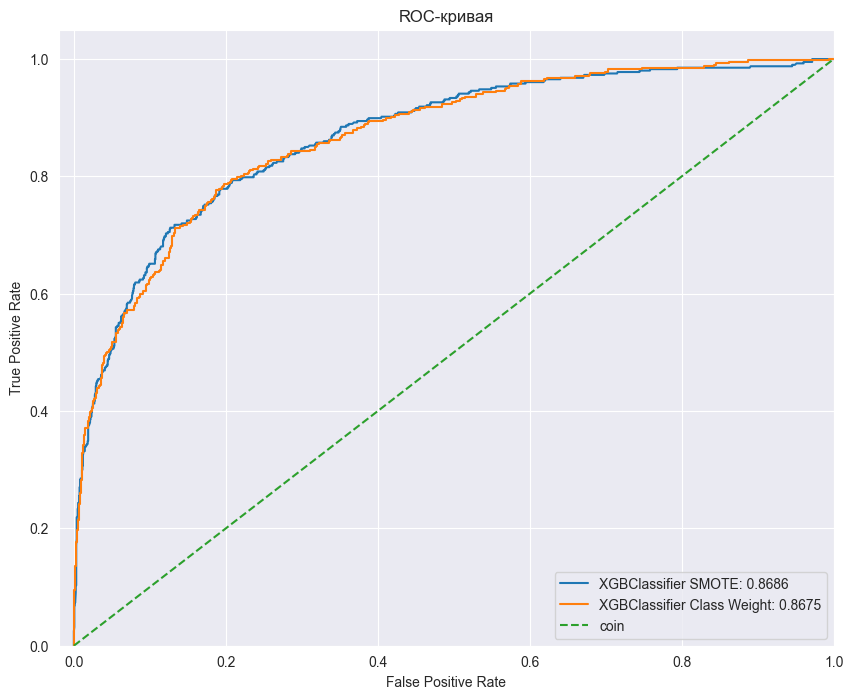

In [88]:
plt.figure(figsize=(10, 8))

fpr, tpr, thresholds = roc_curve(y_test, pred_proba_xgb_smote)
plt.plot(fpr, tpr, label=f'XGBClassifier SMOTE: {round(roc_auc_score(y_test, pred_proba_xgb_smote), 4)}')

fpr, tpr, thresholds = roc_curve(y_test, pred_proba_xgb_cw)
plt.plot(fpr, tpr, label=f'XGBClassifier Class Weight: {round(roc_auc_score(y_test, pred_proba_xgb_cw), 4)}')

plt.plot([0, 1], [0, 1], linestyle='--', label='coin')

plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.legend(loc='lower right')

plt.show()

In [89]:
# сохраним лучшую модель:
joblib.dump(best_model_smote, 'best_model.pkl')

['best_model.pkl']

В ходе работы над проектом были проделаны следующие шаги:

1) Подготовлены данные к исследованию, а именно:

- убраны из данных неинформативные столбцы с номером строки, номером ID и фамилией клиента;

- обработаны пропуски в столбце Tenure - период, в течение которого человек является клиентом банка;

- сделано кодирование категориальных признаков методом One-Hot Encoding, подходящим для разных видов ML;

- данные поделены на тренировочную и тестовую выборки;

- проверен датасет на сбалансированность классов в таргете (20% положительных ответов);

- выполнена трансформация Йео-Джонсона;

- сделано масштабирование численных признаков для моделей SVM и логистической регрессии.

2) Проведено исследование задачи: построены четыре модели классификации: XGBoost, Случайный лес, Метод опорных векторов и Логистическая регрессия.

3) Устранен дисбаланс классов двумя способами: с помощью применения техники SMOTE и добавления модели гиперпараметра class_weight. На новых данных модель XGBClassifier показала результат выше при применении техники SMOTE (F1-мера равна 0.6327). Применение гиперпараметра class_weight оказалось чуть менее эффективно, однако и тут подбор гиперпараметров с изменением веса редкого класса помог довести показатель F1-меры до 0.6141. 

4) Проведено тестирование финальной модели на тестовой выборке. Можно подтвердить, что нам получилось справиться с дисбалансом классов и удалось получить метрику f1 > 0.59.

In [90]:
datalist = df.to_dict(orient='records')

In [91]:
payload = {'bank': datalist} 

In [92]:
payload

{'bank': [{'CreditScore': 619,
   'Geography': 'France',
   'Gender': 'Female',
   'Age': 42,
   'Tenure': 2.0,
   'Balance': 0.0,
   'NumOfProducts': 1,
   'HasCrCard': 1,
   'IsActiveMember': 1,
   'EstimatedSalary': 101348.88,
   'Exited': 1},
  {'CreditScore': 608,
   'Geography': 'Spain',
   'Gender': 'Female',
   'Age': 41,
   'Tenure': 1.0,
   'Balance': 83807.86,
   'NumOfProducts': 1,
   'HasCrCard': 0,
   'IsActiveMember': 1,
   'EstimatedSalary': 112542.58,
   'Exited': 0},
  {'CreditScore': 502,
   'Geography': 'France',
   'Gender': 'Female',
   'Age': 42,
   'Tenure': 8.0,
   'Balance': 159660.8,
   'NumOfProducts': 3,
   'HasCrCard': 1,
   'IsActiveMember': 0,
   'EstimatedSalary': 113931.57,
   'Exited': 1},
  {'CreditScore': 699,
   'Geography': 'France',
   'Gender': 'Female',
   'Age': 39,
   'Tenure': 1.0,
   'Balance': 0.0,
   'NumOfProducts': 2,
   'HasCrCard': 0,
   'IsActiveMember': 0,
   'EstimatedSalary': 93826.63,
   'Exited': 0},
  {'CreditScore': 850,
   'G

In [93]:
data = df.to_json(orient='split')

In [94]:
payload = {'data': data}

In [95]:
result = requests.post('http://127.0.0.1:8001/best_model', json=payload)

In [96]:
result.json()

{'pred': '{"columns":[0],"index":[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,

In [97]:
res = pd.read_json(result.json()['pred'], orient='split')

In [98]:
res

,0
0,1
1,0
2,1
3,0
4,0
...,...
9995,0
9996,0
9997,0
9998,0
